In [3]:
!pip3 install pandas numpy matplotlib seaborn scikit-learn tqdm 

  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached numpy-2.2.4-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.8 MB/s eta 0:00:00
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 9.8 MB/s eta 0:00:00
  Using cached pillow-11.1.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.8 MB/s eta 0:00:00
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl (11.4 MB)
Using cached numpy-2.2.4-cp312-cp312-macos

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor
import os
from tqdm import tqdm
from sklearn.impute import KNNImputer
from sklearn.base import clone
from sklearn.linear_model import LassoCV


In [164]:
# Constants
SEED = 42

In [165]:
# Loading the datasets
train_file_path = "train.csv"
train_df = pd.read_csv(train_file_path)
test_file_path = "test.csv"
test_df = pd.read_csv(test_file_path)
df = train_df

In [166]:
# Basic Info about Dataset
print("\n🔹 Dataset Info:")
print(df.info())


🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898

In [167]:
# Checking for Missing Values
print("\n🔍 Missing Values Count:")
print(df.isnull().sum())


🔍 Missing Values Count:
id                                           0
Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
CGAS-CGAS_Score                           1539
Physical-Season                            650
Physical-BMI                               938
Physical-Height                            933
Physical-Weight                            884
Physical-Waist_Circumference              3062
Physical-Diastolic_BP                     1006
Physical-HeartRate                         993
Physical-Systolic_BP                      1006
Fitness_Endurance-Season                  2652
Fitness_Endurance-Max_Stage               3217
Fitness_Endurance-Time_Mins               3220
Fitness_Endurance-Time_Sec                3220
FGC-Season                                 614
FGC-FGC_CU                                1638
FGC-FGC_CU_Zone                    

In [168]:
# Summary Statistics
print("\n📊 Summary Statistics (Numerical Features):")
print(df.describe())


📊 Summary Statistics (Numerical Features):
       Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
count      3960.000000      3960.000000      2421.000000   3022.000000   
mean         10.433586         0.372727        65.454771     19.331929   
std           3.574648         0.483591        22.341862      5.113934   
min           5.000000         0.000000        25.000000      0.000000   
25%           8.000000         0.000000        59.000000     15.869350   
50%          10.000000         0.000000        65.000000     17.937682   
75%          13.000000         1.000000        75.000000     21.571244   
max          22.000000         1.000000       999.000000     59.132048   

       Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
count      3027.000000      3076.000000                    898.000000   
mean         55.946713        89.038615                     27.278508   
std           7.473764        44.569040                      5.567287 

In [169]:
# Identify Categorical & Numerical Columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

print(f"\n📝 Categorical Columns: {list(categorical_cols)}")
print(f"\n🔢 Numerical Columns: {list(numerical_cols)}")


📝 Categorical Columns: ['id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']

🔢 Numerical Columns: ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA

In [170]:
len(numerical_cols)

70

/var/folders/60/hg2z_sq10k915qgkzmq5z6km0000gn/T/ipykernel_33116/2606850753.py:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 2000x4200 with 0 Axes>

/Users/anushreearora/Desktop/NTU/Y4/SC4000/Child-Mind-Institute-Problematic-Internet-Use/mlenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


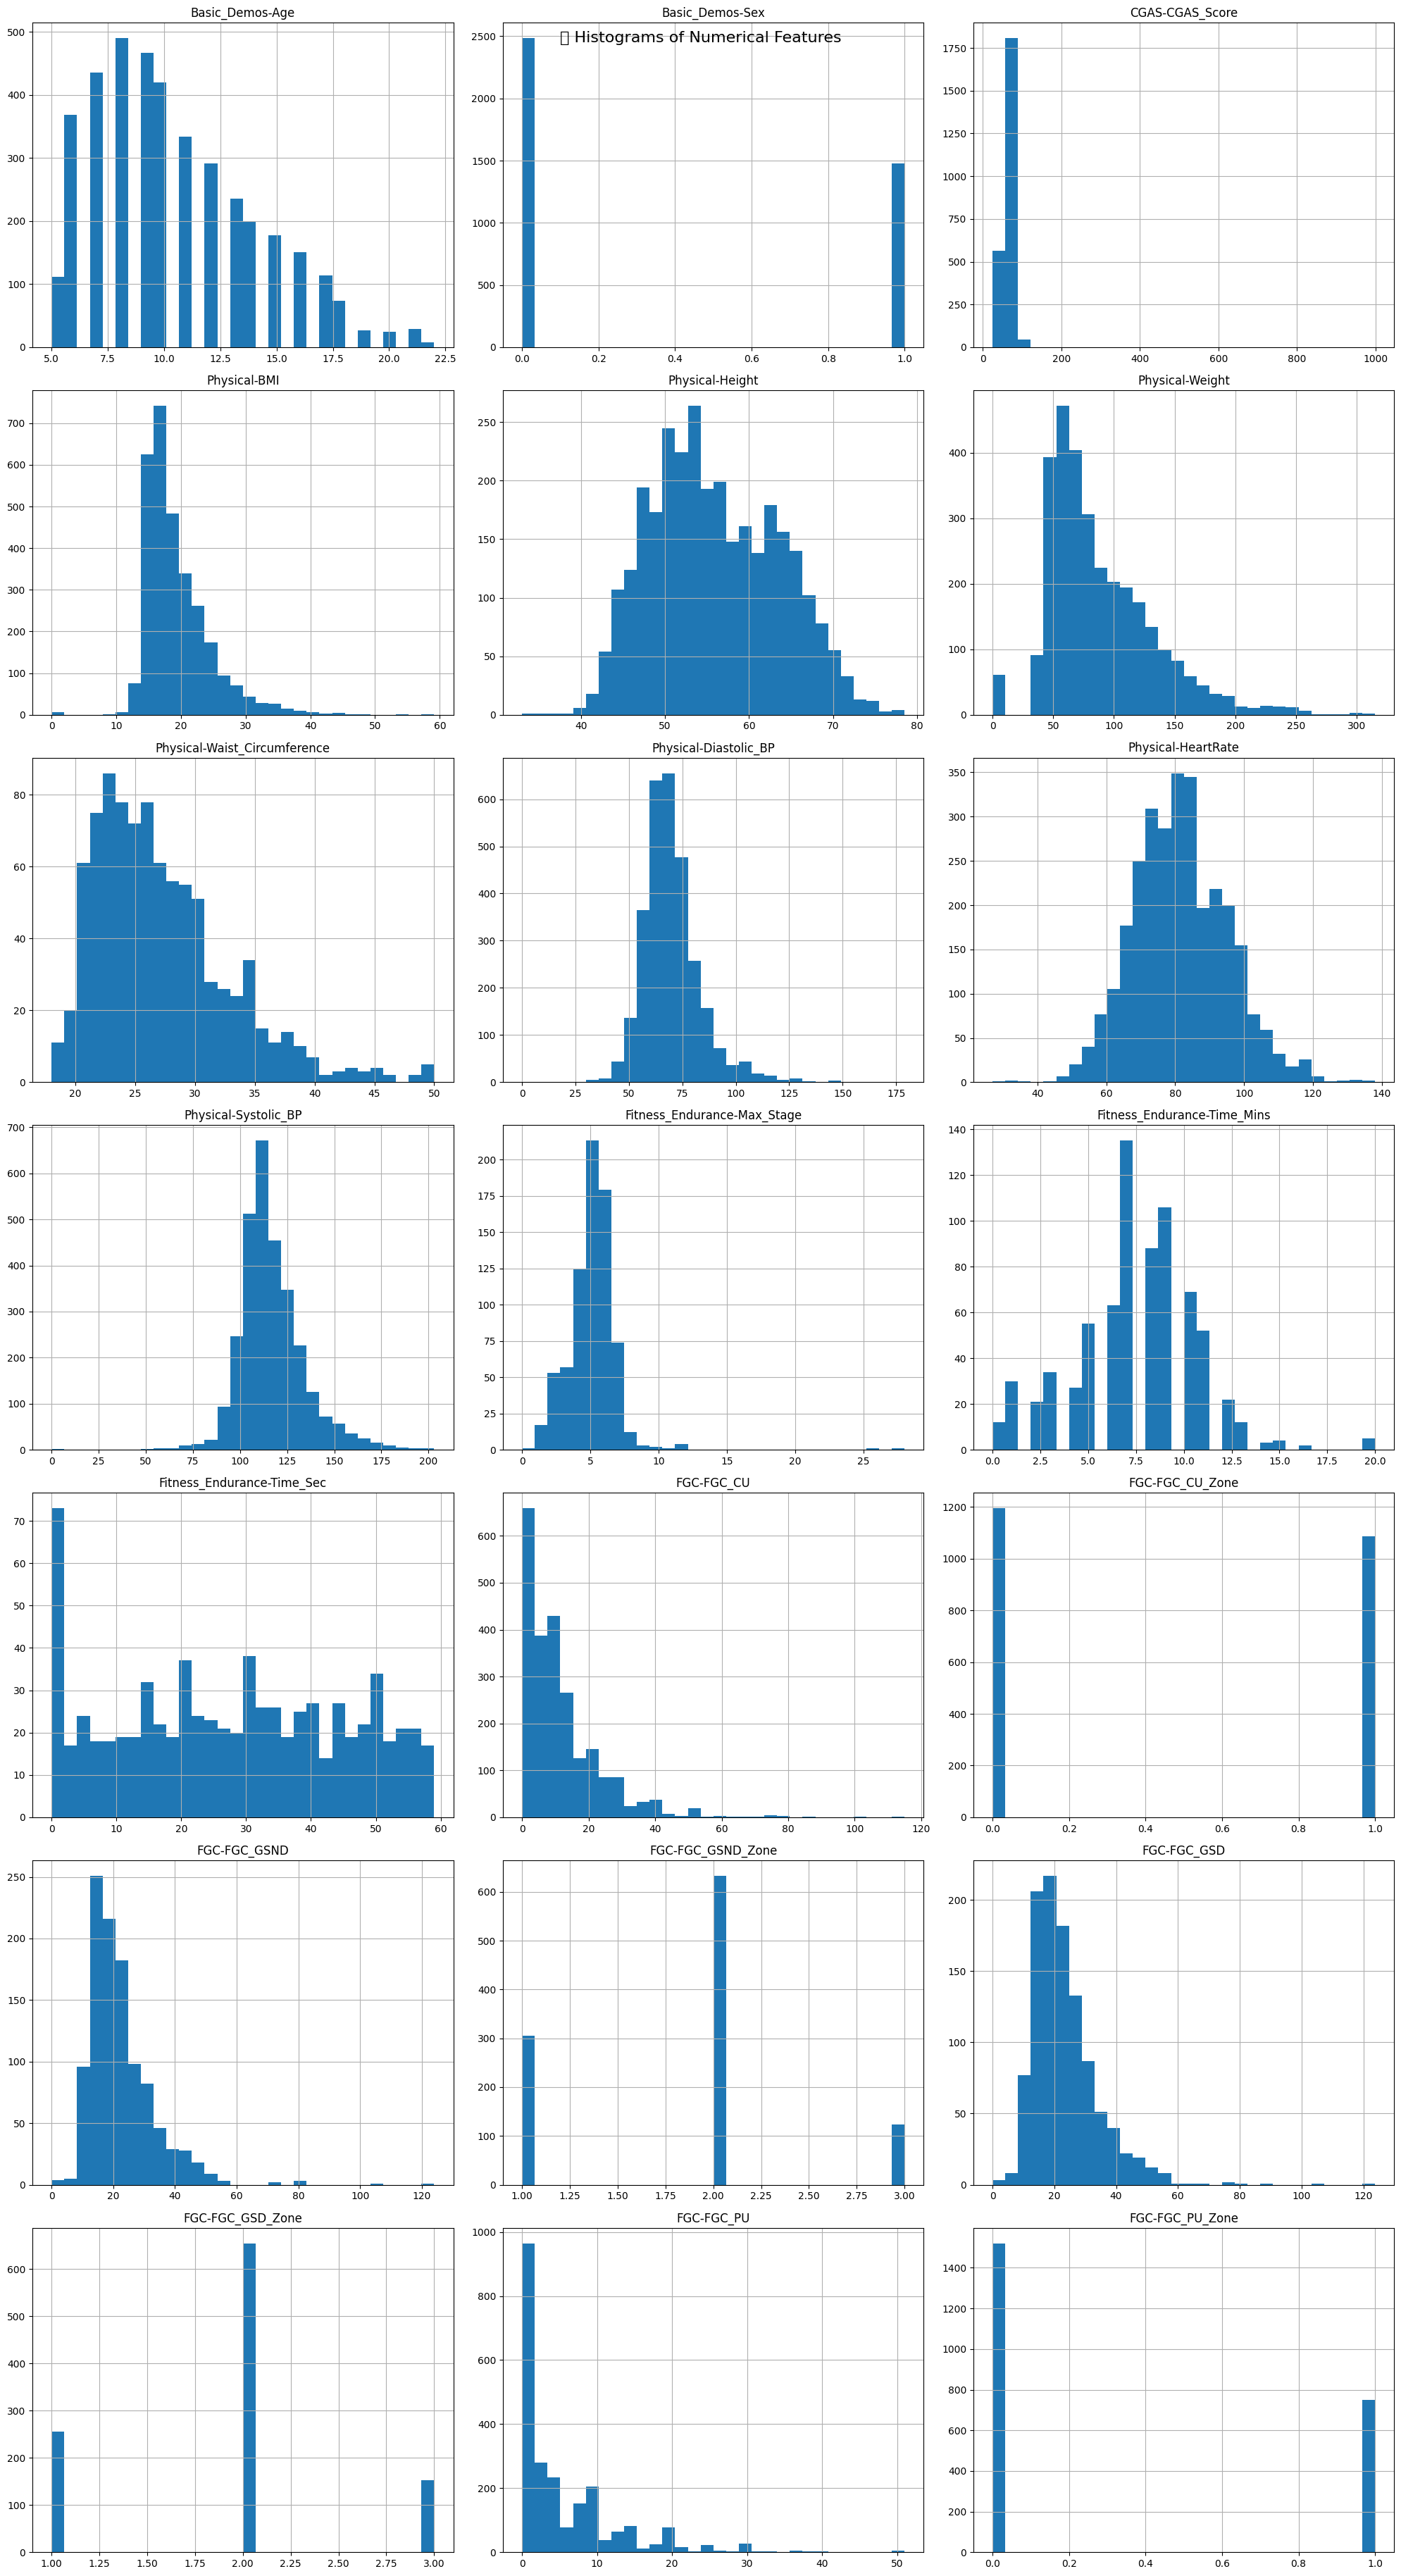

In [171]:
# Plot Histograms for Numerical Data
fig_height = len(numerical_cols[0:21]) * 2 
plt.figure(figsize=(20, fig_height))
df[numerical_cols[0:21]].hist(bins=30, figsize=(20, fig_height), layout=(len(numerical_cols[0:21])//3 + 1, 3))
plt.suptitle("📊 Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()


/var/folders/60/hg2z_sq10k915qgkzmq5z6km0000gn/T/ipykernel_33116/2576632660.py:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 2000x4200 with 0 Axes>

/Users/anushreearora/Desktop/NTU/Y4/SC4000/Child-Mind-Institute-Problematic-Internet-Use/mlenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


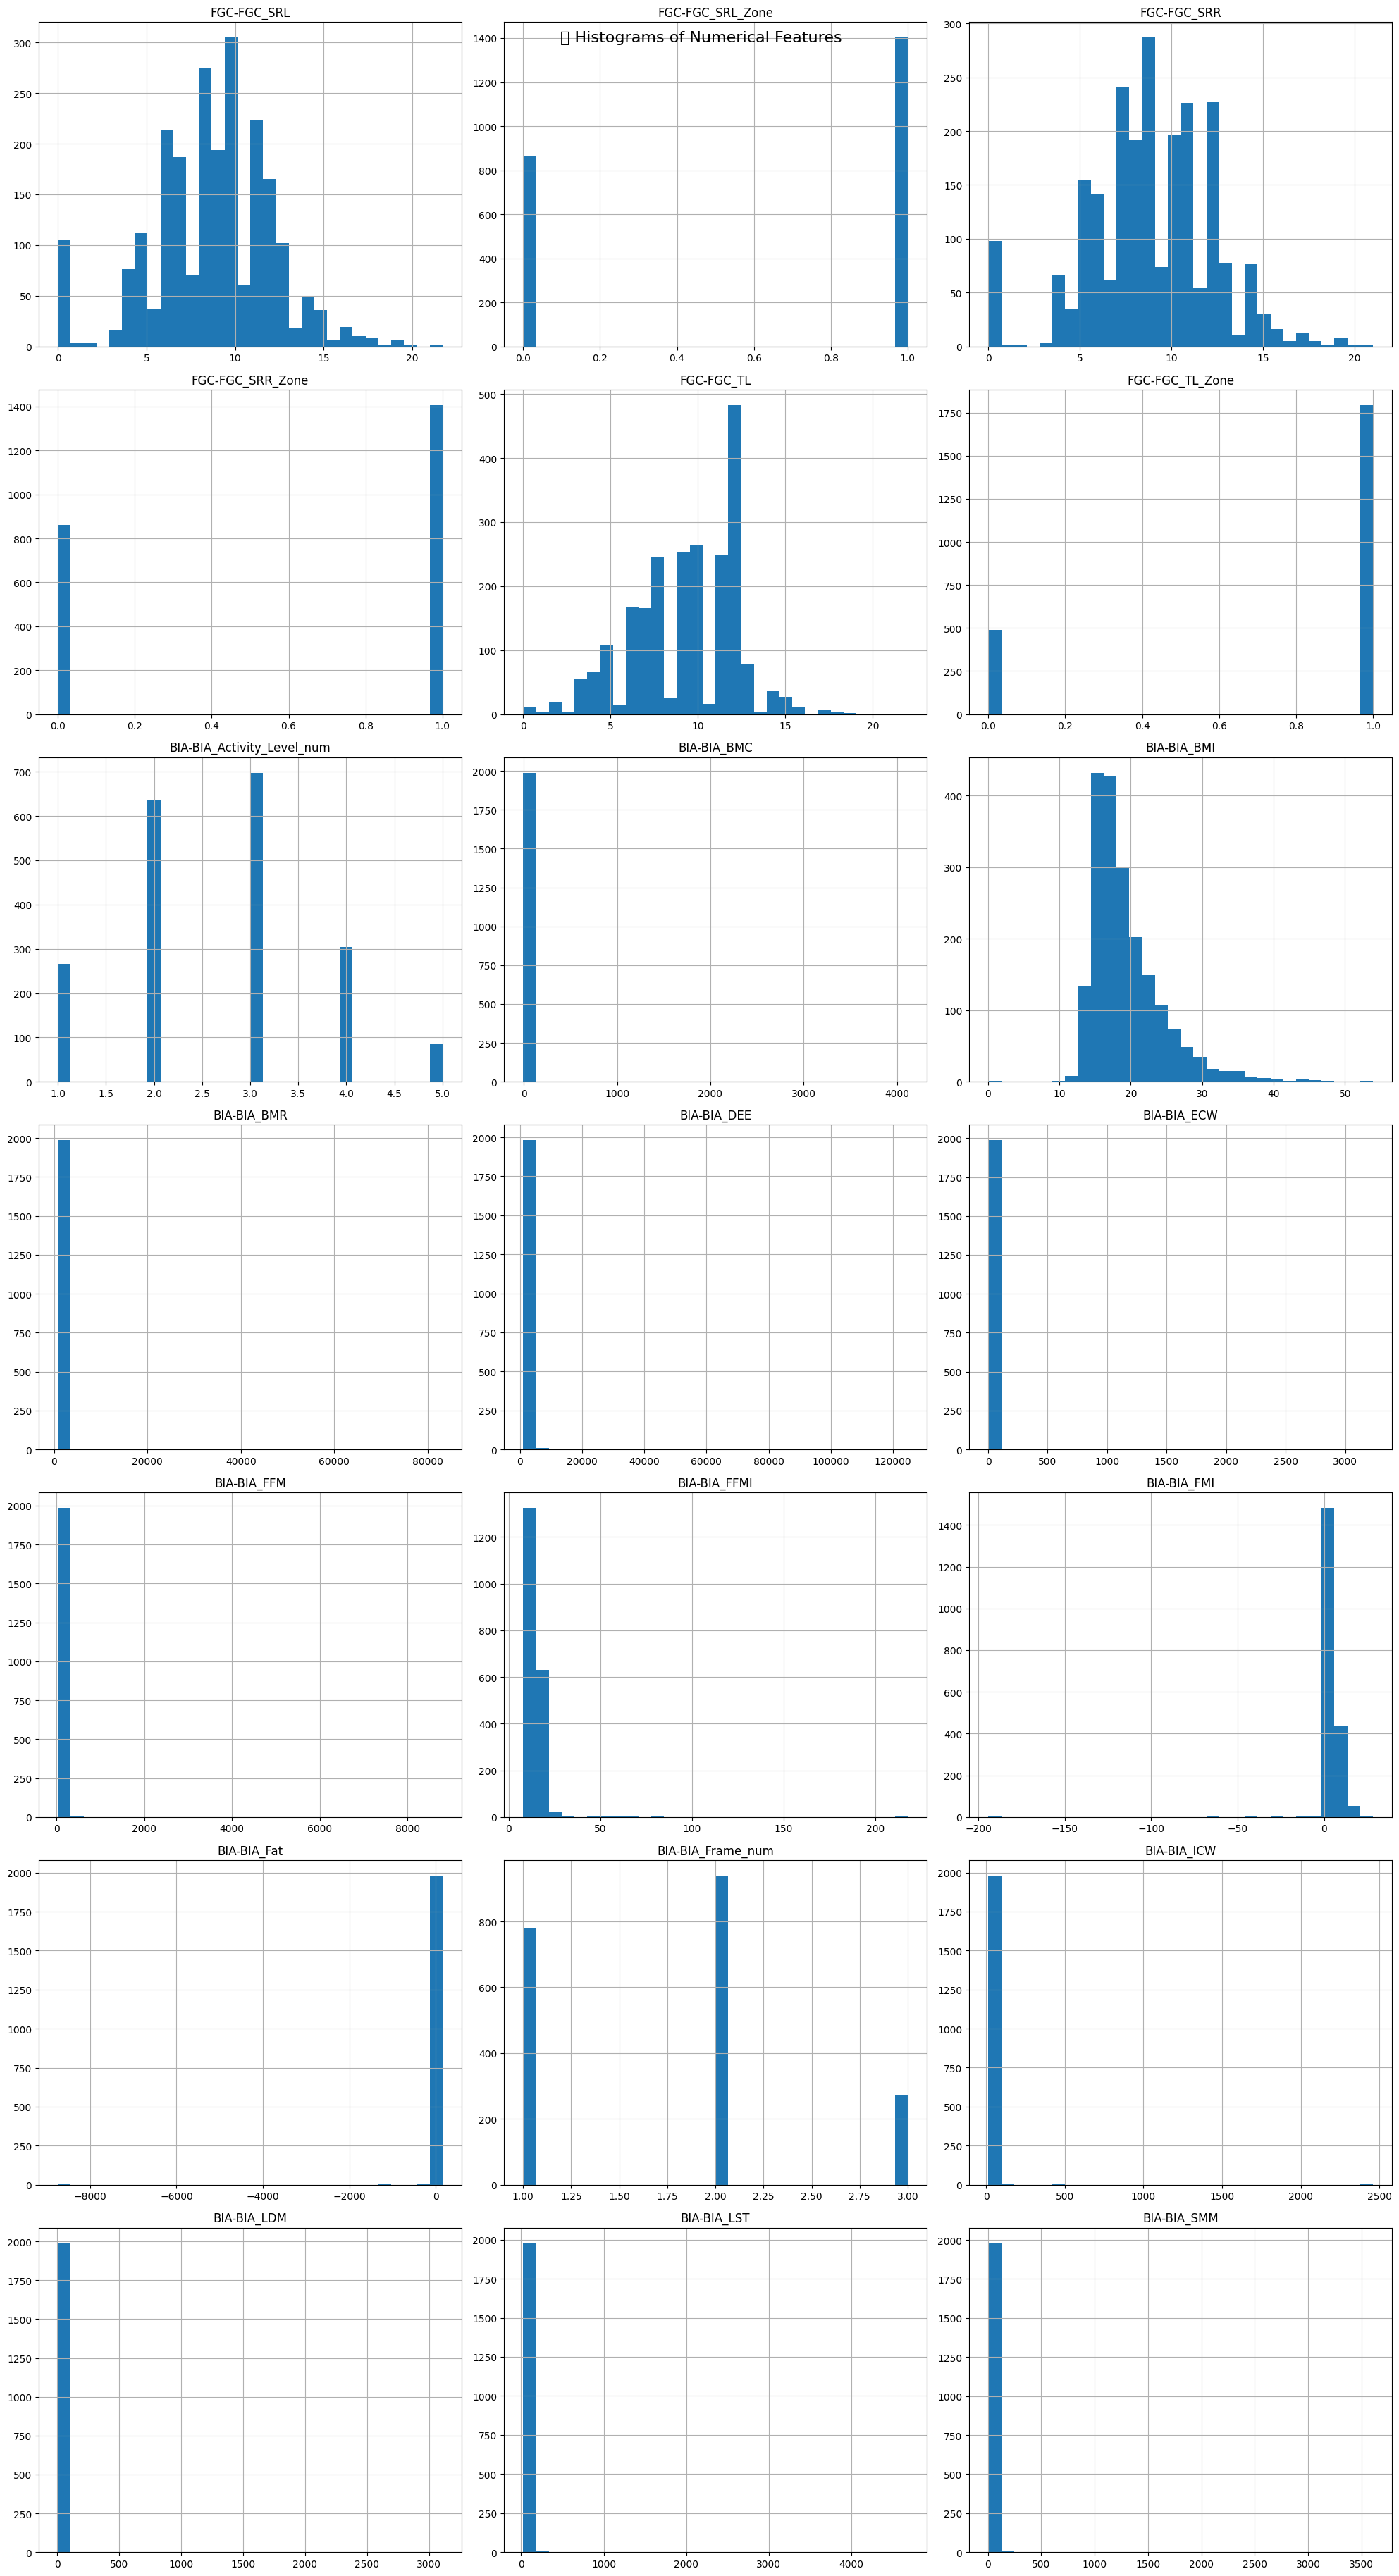

In [172]:
# Plot Histograms for Numerical Data
fig_height = len(numerical_cols[21:42]) * 2 
plt.figure(figsize=(20, fig_height))
df[numerical_cols[21:42]].hist(bins=30, figsize=(20, fig_height), layout=(len(numerical_cols[21:42])//3 + 1, 3))
plt.suptitle("📊 Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()


/var/folders/60/hg2z_sq10k915qgkzmq5z6km0000gn/T/ipykernel_33116/3264803653.py:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 2000x4200 with 0 Axes>

/Users/anushreearora/Desktop/NTU/Y4/SC4000/Child-Mind-Institute-Problematic-Internet-Use/mlenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


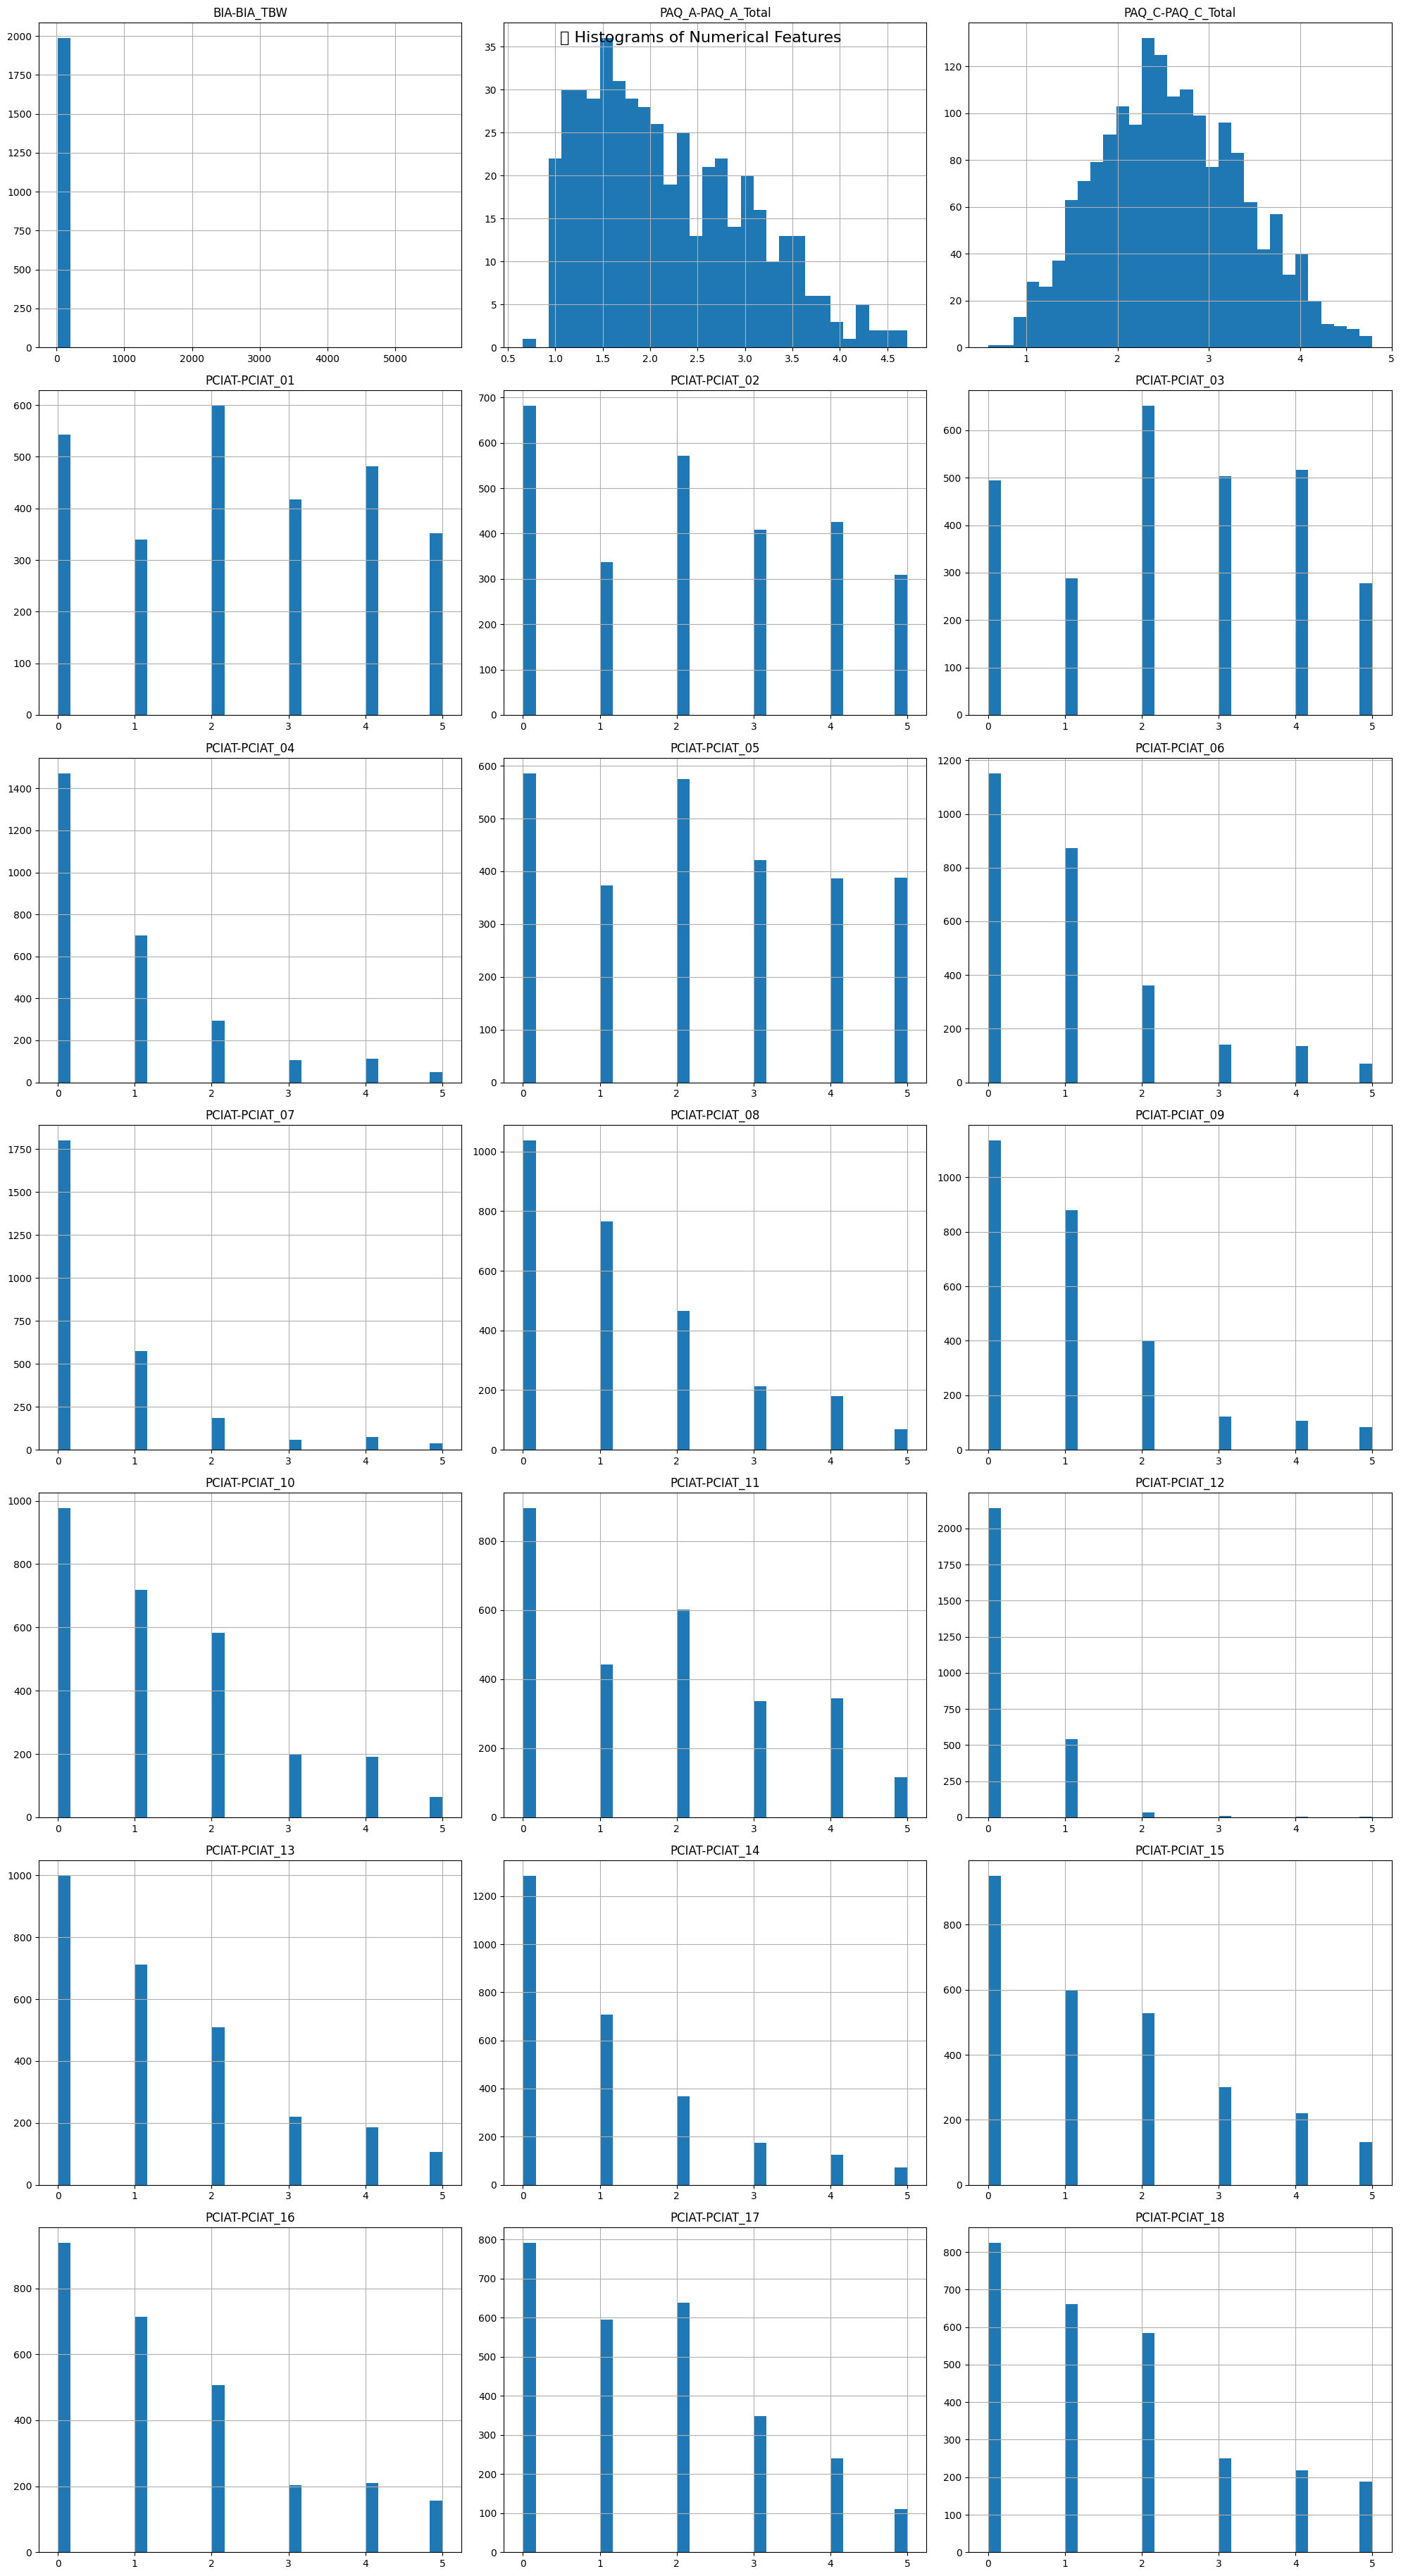

In [173]:
# Plot Histograms for Numerical Data
fig_height = len(numerical_cols[42:63]) * 2 
plt.figure(figsize=(20, fig_height))
df[numerical_cols[42:63]].hist(bins=30, figsize=(20, fig_height), layout=(len(numerical_cols[42:63])//3 + 1, 3))
plt.suptitle("📊 Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()


/var/folders/60/hg2z_sq10k915qgkzmq5z6km0000gn/T/ipykernel_33116/3835399444.py:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 2000x1400 with 0 Axes>

/Users/anushreearora/Desktop/NTU/Y4/SC4000/Child-Mind-Institute-Problematic-Internet-Use/mlenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


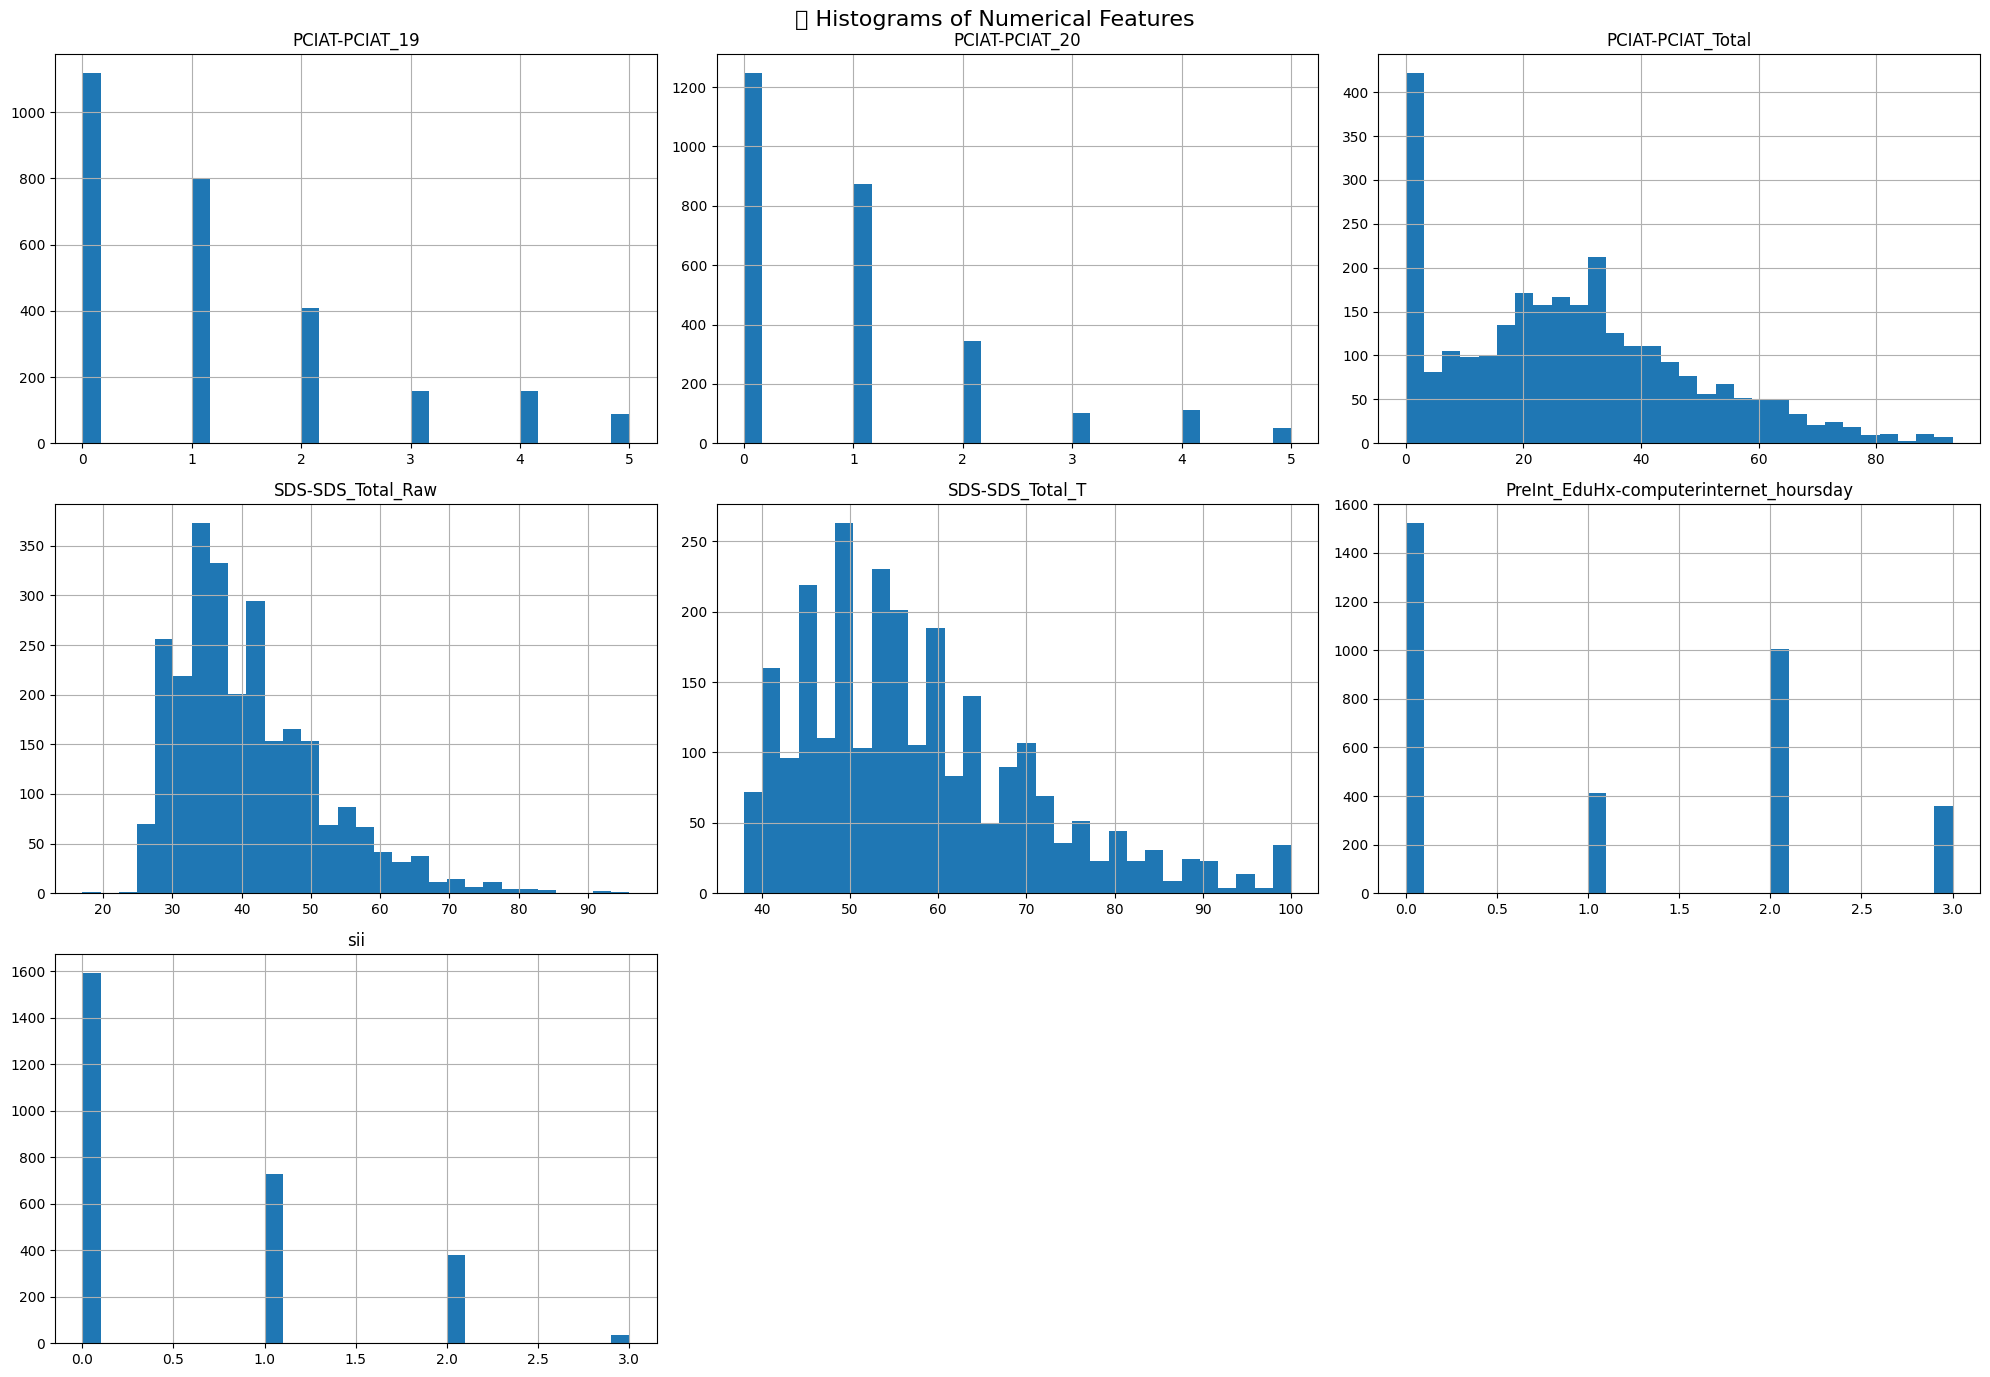

In [174]:
# Plot Histograms for Numerical Data
fig_height = len(numerical_cols[63:]) * 2 
plt.figure(figsize=(20, fig_height))
df[numerical_cols[63:]].hist(bins=30, figsize=(20, fig_height), layout=(len(numerical_cols[63:])//3 + 1, 3))
plt.suptitle("📊 Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()


In [175]:
# Displays the minimum and maximum values of the PCIAT-PCIAT_Total column for each sii group.
display(df.groupby('sii').min()['PCIAT-PCIAT_Total'])
display(df.groupby('sii').max()['PCIAT-PCIAT_Total'])

TypeError: agg function failed [how->min,dtype->object]

In [176]:
## Correlation
covariance_matrix = df.select_dtypes(include=['float64','int64']).corr()
display(covariance_matrix)

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
Basic_Demos-Age,1.000000,0.064004,-0.009994,0.492112,0.880274,0.748149,0.609601,0.107960,-0.218527,0.263875,...,0.085805,0.286888,0.159826,0.303259,0.286309,0.409559,0.037317,0.037115,0.441822,0.365990
Basic_Demos-Sex,0.064004,1.000000,0.075470,0.025793,-0.014454,0.003245,-0.020013,0.002076,0.026675,-0.025256,...,-0.097824,-0.102390,-0.110080,-0.104911,-0.067966,-0.093648,-0.020122,-0.018508,-0.000579,-0.100148
CGAS-CGAS_Score,-0.009994,0.075470,1.000000,-0.094074,-0.023185,-0.076399,-0.076116,-0.005292,-0.010108,-0.021392,...,-0.065687,-0.047770,-0.067922,-0.065210,-0.067920,-0.070542,-0.145369,-0.148457,-0.021596,-0.085261
Physical-BMI,0.492112,0.025793,-0.094074,1.000000,0.487097,0.865662,0.892149,0.141795,-0.036955,0.312045,...,0.071017,0.152122,0.100032,0.181208,0.161034,0.240858,0.087655,0.086185,0.296709,0.221125
Physical-Height,0.880274,-0.014454,-0.023185,0.487097,1.000000,0.833844,0.688033,0.115724,-0.217080,0.299157,...,0.112369,0.300590,0.184409,0.307084,0.292542,0.420765,0.036687,0.036478,0.399367,0.373530
Physical-Weight,0.748149,0.003245,-0.076399,0.865662,0.833844,1.000000,0.916710,0.145480,-0.134071,0.355700,...,0.095449,0.236919,0.148172,0.264149,0.245022,0.353048,0.075098,0.073482,0.375851,0.325938
Physical-Waist_Circumference,0.609601,-0.020013,-0.076116,0.892149,0.688033,0.916710,1.000000,0.195975,-0.090119,0.388621,...,0.060389,0.217028,0.135397,0.254455,0.212407,0.327013,0.089831,0.091152,0.371418,0.272885
Physical-Diastolic_BP,0.107960,0.002076,-0.005292,0.141795,0.115724,0.145480,0.195975,1.000000,0.148024,0.657705,...,0.015915,0.047003,0.032866,0.049475,0.028275,0.069321,0.006702,0.008502,0.074258,0.050971
Physical-HeartRate,-0.218527,0.026675,-0.010108,-0.036955,-0.217080,-0.134071,-0.090119,0.148024,1.000000,0.122261,...,0.011719,-0.021856,0.006923,-0.006803,-0.034419,-0.037594,0.049194,0.047932,-0.073453,-0.024572
Physical-Systolic_BP,0.263875,-0.025256,-0.021392,0.312045,0.299157,0.355700,0.388621,0.657705,0.122261,1.000000,...,0.048735,0.093580,0.074699,0.101469,0.084332,0.147081,0.036562,0.038317,0.137728,0.135336


In [177]:
numeric_df = train_df.select_dtypes(include='number')

min_max_df = pd.DataFrame({
    'Min': numeric_df.min(),
    'Max': numeric_df.max()
}).sort_values(by='Min', ascending=True)  # or sort by 'Max' if preferred

print(min_max_df)

                                                Min            Max
BIA-BIA_Fat                            -8745.080000     153.820000
BIA-BIA_FMI                             -194.163000      28.251500
BIA-BIA_BMC                               -7.789610    4115.360000
sii                                        0.000000       3.000000
FGC-FGC_TL_Zone                            0.000000       1.000000
PCIAT-PCIAT_10                             0.000000       5.000000
PCIAT-PCIAT_17                             0.000000       5.000000
PCIAT-PCIAT_16                             0.000000       5.000000
PCIAT-PCIAT_15                             0.000000       5.000000
PreInt_EduHx-computerinternet_hoursday     0.000000       3.000000
PCIAT-PCIAT_14                             0.000000       5.000000
PCIAT-PCIAT_13                             0.000000       5.000000
PCIAT-PCIAT_12                             0.000000       5.000000
PCIAT-PCIAT_01                             0.000000       5.00

In [178]:
def clean_data(df):
    
    # season_colums = [col for col in train_df.columns if 'Season' in col]
    # df = df.drop(season_colums, axis=1) # Removes columns with 'Season' in the name

    df = df.drop(columns=['id'])
    
    df["BIA-BIA_Fat"] = df["BIA-BIA_Fat"].abs() # Replaces negative values with positive values

    df["BIA-BIA_FMI"] = df["BIA-BIA_FMI"].abs() # Replaces negative values with positive values

    df.loc[df["BIA-BIA_Fat"] > 65, "BIA-BIA_Fat"] = np.nan # Replaces values greater than 65 with NaN - more than 65% body fat is not possible

    df.loc[df["BIA-BIA_Fat"] < 5, "BIA-BIA_Fat"] = np.nan # Replaces values less than 5 with NaN - less 5% body fat is not possible

    df.loc[df["BIA-BIA_FMI"] > 40, "BIA-BIA_FMI"] = np.nan # Replaces values greater than 40 with NaN

    df[['FGC-FGC_GSND', 'FGC-FGC_GSD']] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].clip(lower=0, upper=100) # Replaces values less than 0 with 0 and values greater than 100 with 100

    df.loc[df["BIA-BIA_BMR"] > 4000, "BIA-BIA_BMR"] = np.nan # Replaces values greater than 4000 with NaN

    df.loc[df["BIA-BIA_DEE"] > 8000, "BIA-BIA_DEE"] = np.nan # Replaces values greater than 8000 with NaN

    df["BIA-BIA_BMC"] = df["BIA-BIA_BMC"].abs() # Replaces negative values with positive values

    df[['BIA-BIA_BMC']] = df[['BIA-BIA_BMC']].clip(lower=0, upper=10) # Replaces values less than 0 with 0 and values greater than 10 with 10

    df.loc[df["BIA-BIA_BMC"] == 0, "BIA-BIA_BMC"] = np.nan # Replaces values equal to 0 with NaN

    df.loc[df["BIA-BIA_FFM"] > 400, "BIA-BIA_FFM"] = np.nan # Replaces values greater than 400 with NaN

    df.loc[df["BIA-BIA_ECW"] > 100, "BIA-BIA_ECW"] = np.nan # Replaces values greater than 100 with NaN

    df.loc[df["BIA-BIA_ICW"] > 100, "BIA-BIA_ICW"] = np.nan # Replaces values greater than 100 with NaN

    df.loc[df["BIA-BIA_LDM"] > 100, "BIA-BIA_LDM"] = np.nan # Replaces values greater than 100 with NaN

    df.loc[df["BIA-BIA_LST"] > 300, "BIA-BIA_LST"] = np.nan # Replaces values greater than 300 with NaN

    df.loc[df["BIA-BIA_TBW"] > 300, "BIA-BIA_TBW"] = np.nan # Replaces values greater than 300 with NaN

    df.loc[df["BIA-BIA_SMM"] > 300, "BIA-BIA_SMM"] = np.nan # Replaces values greater than 300 with NaN

    df.loc[df["Physical-Height"] == 0, "Physical-Height"] = np.nan # Replaces values equal to 0 with NaN

    df.loc[df["Physical-Weight"] == 0, "Physical-Weight"] = np.nan # Replaces values equal to 0 with NaN

    df['PAQ_Total'] = df['PAQ_C-PAQ_C_Total'].fillna(df['PAQ_A-PAQ_A_Total']) # Fills missing values in PAQ_Total with values from PAQ_A-PAQ_A_Total

    df = df.drop('PAQ_C-PAQ_C_Total', axis=1) 
    df = df.drop('PAQ_A-PAQ_A_Total', axis=1)

    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df) 

In [105]:
# Quick function to display the statistics of a column
def get_statistic(df_col):
    print(df_col.describe())

def assign_groups(age):
    thresholds = [5, 10, 15, 18, 22]  # Define the thresholds based on the age groups.
    for i, j in enumerate(thresholds):
        if age <= j:
            return i
    return np.nan

def group_statistics(df, column):
    mean_value = df.groupby('age_group')[column].mean() # Calculate the mean value of the column for each age group.
    print(mean_value)

train_df['age_group'] = train_df['Basic_Demos-Age'].apply(assign_groups) # Apply the function to the 'Demographics-Age' column.
test_df['age_group'] = test_df['Basic_Demos-Age'].apply(assign_groups) # Apply the function to the 'Demographics-Age' column.



In [180]:
pd.reset_option('display.max_rows')

In [181]:
train_df

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,PAQ_Total
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,...,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,...,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,2.340
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,...,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0,2.170
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,...,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0,2.451
4,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,NaN,...,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0,3.260
3956,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,NaN,2.340
3957,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,NaN,...,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0,2.729
3958,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,NaN,...,1.0,1.0,19.0,Spring,33.0,47.0,Spring,1.0,0.0,3.300


In [182]:
pd.set_option('display.max_rows', None)

missing_cols = train_df.isna().sum()
missing_cols = missing_cols[missing_cols > 0]
print(missing_cols)

CGAS-Season                               1405
CGAS-CGAS_Score                           1539
Physical-Season                            650
Physical-BMI                               938
Physical-Height                            933
Physical-Weight                            945
Physical-Waist_Circumference              3062
Physical-Diastolic_BP                     1006
Physical-HeartRate                         993
Physical-Systolic_BP                      1006
Fitness_Endurance-Season                  2652
Fitness_Endurance-Max_Stage               3217
Fitness_Endurance-Time_Mins               3220
Fitness_Endurance-Time_Sec                3220
FGC-Season                                 614
FGC-FGC_CU                                1638
FGC-FGC_CU_Zone                           1678
FGC-FGC_GSND                              2886
FGC-FGC_GSND_Zone                         2898
FGC-FGC_GSD                               2886
FGC-FGC_GSD_Zone                          2897
FGC-FGC_PU   

In [188]:
corr = pd.DataFrame(train_df.select_dtypes(include='number').corr()['PCIAT-PCIAT_Total'].sort_values(ascending = False))
corr

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
sii,0.899681
PCIAT-PCIAT_05,0.830993
PCIAT-PCIAT_15,0.823996
PCIAT-PCIAT_17,0.823708
PCIAT-PCIAT_03,0.823336
PCIAT-PCIAT_18,0.802030
PCIAT-PCIAT_02,0.788802
PCIAT-PCIAT_13,0.771990
PCIAT-PCIAT_08,0.770499


## **Imputations**

#### Height and Weight using KNN Imputation

In [148]:
# 1. Get all columns with missing values
missing_cols = train_df.columns[train_df.isna().any()]

# 2. Get the correlation matrix (numeric columns only)
corr_matrix = train_df.corr(numeric_only=True)

# 3. Define your target columns
target_cols = ['Physical-Height', 'Physical-Weight']

# 4. Find non-missing columns
non_missing_cols = [col for col in train_df.columns if col not in missing_cols]

# 5. For each target, get sorted correlations with non-missing columns
for target in target_cols:
    print(f"\nTop correlated non-missing columns with {target}:\n")
    if target not in corr_matrix:
        print("No correlation available (likely too many NaNs).")
        continue
    correlations = corr_matrix[target].dropna()
    correlations = correlations[correlations.index.isin(non_missing_cols) & (correlations.index != target)]
    print(f"Found {len(correlations)} valid correlations")
    print(correlations.sort_values(ascending=False).head(10))


Top correlated non-missing columns with Physical-Height:

Found 2 valid correlations
Basic_Demos-Age    0.880274
Basic_Demos-Sex   -0.014454
Name: Physical-Height, dtype: float64

Top correlated non-missing columns with Physical-Weight:

Found 2 valid correlations
Basic_Demos-Age    0.781934
Basic_Demos-Sex    0.003113
Name: Physical-Weight, dtype: float64


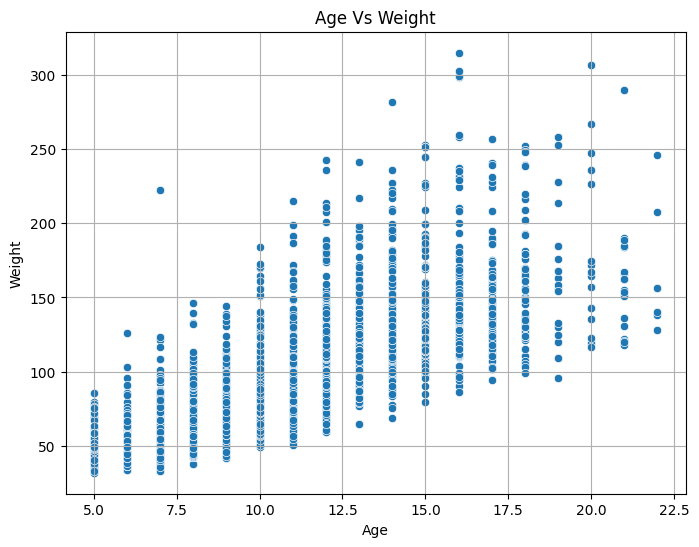

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Basic_Demos-Age',
    y='Physical-Weight'
)
plt.title('Age Vs Weight')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

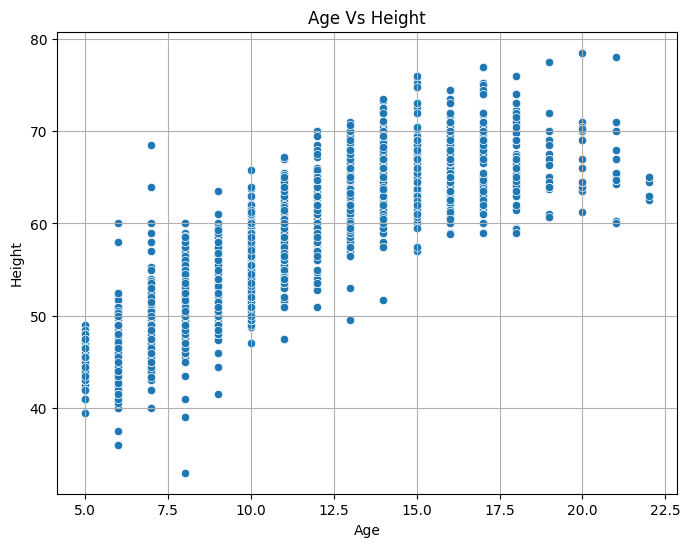

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Basic_Demos-Age',
    y='Physical-Height'
)
plt.title('Age Vs Height')
plt.xlabel('Age')
plt.ylabel('Height')
plt.grid(True)
plt.show()

In [151]:
train_df['Physical-Height'].min()

np.float64(33.0)

In [152]:
columns = ['Physical-Height', 'Physical-Weight', 'Basic_Demos-Age', 'Basic_Demos-Sex']

# Select only these columns for imputation
subset = train_df[columns]

# Run KNN imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
imputed = pd.DataFrame(imputer.fit_transform(subset), columns=columns)

# Replace the imputed columns in the original dataframe
train_df['Physical-Height'] = imputed['Physical-Height']
train_df['Physical-Weight'] = imputed['Physical-Weight']

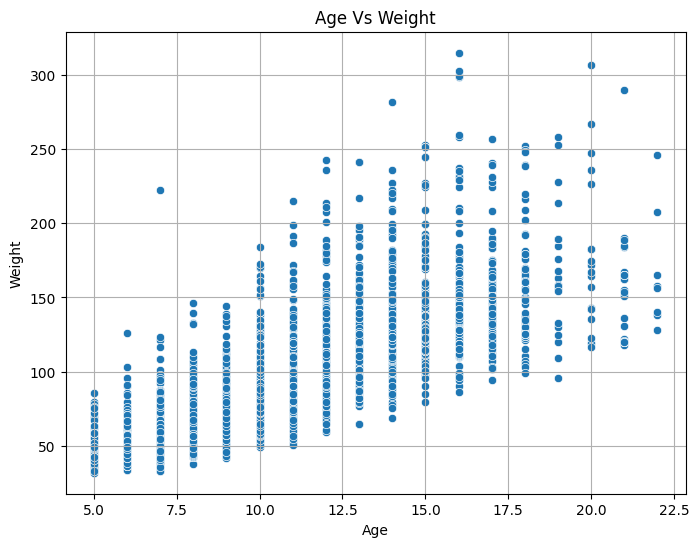

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Basic_Demos-Age',
    y='Physical-Weight'
)
plt.title('Age Vs Weight')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

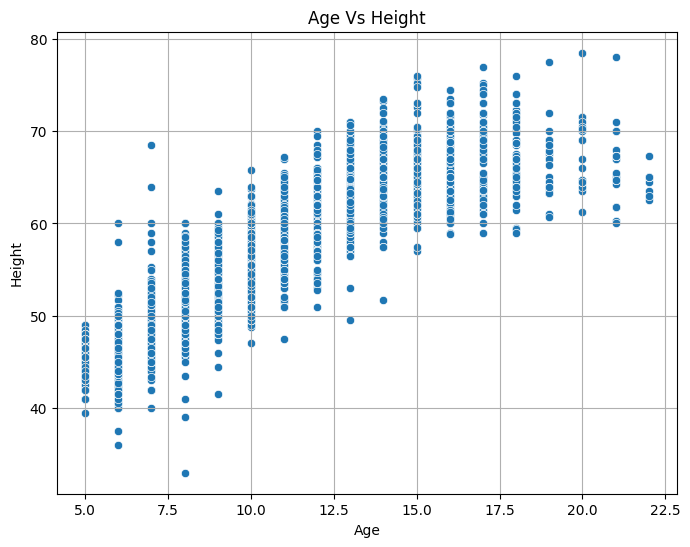

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Basic_Demos-Age',
    y='Physical-Height'
)
plt.title('Age Vs Height')
plt.xlabel('Age')
plt.ylabel('Height')
plt.grid(True)
plt.show()

#### Imputing BMI using height and weight

In [155]:
train_df['Physical-Weight'] = train_df['Physical-Weight'] * 0.453592 

In [156]:
train_df['Physical-Height'] = train_df['Physical-Height'] * 0.0254

In [157]:
mask = train_df['Physical-Weight'].notna() & train_df['Physical-Height'].notna()

# Overwrite full BMI column with NaNs first
train_df['Physical-BMI'] = np.nan

# Fill only where data is available
train_df.loc[mask, 'Physical-BMI'] = (
    train_df.loc[mask, 'Physical-Weight'] / (train_df.loc[mask, 'Physical-Height'] ** 2)
)

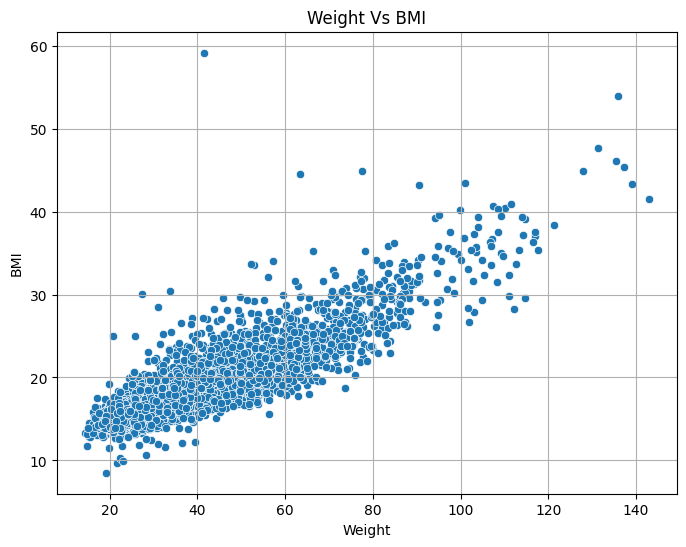

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Physical-Weight',
    y='Physical-BMI'
)
plt.title('Weight Vs BMI')
plt.xlabel('Weight')
plt.ylabel('BMI')
plt.grid(True)
plt.show()

In [203]:
train_df = train_df.drop(columns=['BIA-BIA_BMI'])

#### Impute waist circumference using linear regression

In [159]:
# 1. Get all columns with missing values
missing_cols = train_df.columns[train_df.isna().any()]

# 2. Get the correlation matrix (numeric columns only)
corr_matrix = train_df.corr(numeric_only=True)

# 3. Define your target columns
target_cols = ['Physical-Waist_Circumference']

# 4. Find non-missing columns
non_missing_cols = [col for col in train_df.columns if col not in missing_cols]

# 5. For each target, get sorted correlations with non-missing columns
for target in target_cols:
    print(f"\nTop correlated non-missing columns with {target}:\n")
    if target not in corr_matrix:
        print("No correlation available (likely too many NaNs).")
        continue
    correlations = corr_matrix[target].dropna()
    correlations = correlations[correlations.index.isin(non_missing_cols) & (correlations.index != target)]
    print(f"Found {len(correlations)} valid correlations")
    print(correlations.sort_values(ascending=False).head(10))


Top correlated non-missing columns with Physical-Waist_Circumference:

Found 5 valid correlations
Physical-Weight    0.915839
Physical-BMI       0.891014
Physical-Height    0.688211
Basic_Demos-Age    0.609601
Basic_Demos-Sex   -0.020013
Name: Physical-Waist_Circumference, dtype: float64


In [160]:
columns = ['Physical-Weight', 'Physical-BMI', 'Physical-Waist_Circumference']

# Select only these columns for imputation
subset = train_df[columns]

# Run linear regression imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

imputer = IterativeImputer(estimator=BayesianRidge())
imputed = pd.DataFrame(imputer.fit_transform(subset),columns=columns)

# Replace the imputed columns in the original dataframe
train_df['Physical-Waist_Circumference'] = imputed['Physical-Waist_Circumference']

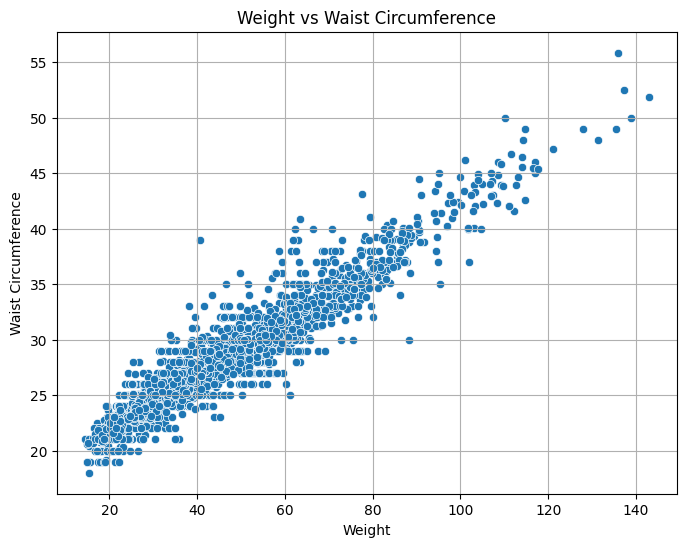

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Physical-Weight',
    y='Physical-Waist_Circumference'
)
plt.title('Weight vs Waist Circumference')
plt.xlabel('Weight')
plt.ylabel('Waist Circumference')
plt.grid(True)
plt.show()

In [87]:
train_df['Physical-Waist_Circumference'].isna().sum()

np.int64(0)

#### Imputing SDS-Total-Raw using KNN Imputation


In [189]:
equal_mask = train_df['SDS-SDS_Total_T'] == train_df['SDS-SDS_Total_Raw']
print(f"{equal_mask.sum()} records have equal values.")

0 records have equal values.


In [190]:
train_df['SDS_Diff'] = train_df['SDS-SDS_Total_T'] - train_df['SDS-SDS_Total_Raw']
train_df['SDS_Diff']

0        NaN
1       18.0
2       16.0
3       14.0
4        NaN
5       16.0
6       13.0
7        NaN
8        NaN
9        NaN
10       NaN
11      17.0
12      14.0
13       NaN
14       NaN
15      15.0
16      16.0
17       NaN
18      16.0
19       NaN
20      13.0
21       NaN
22      20.0
23      19.0
24      15.0
25      13.0
26       NaN
27      16.0
28      15.0
29       NaN
30       NaN
31      13.0
32      24.0
33       NaN
34       NaN
35       NaN
36      16.0
37       NaN
38      25.0
39       NaN
40      19.0
41      19.0
42       NaN
43       NaN
44      14.0
45      15.0
46      17.0
47       NaN
48      14.0
49      16.0
50      17.0
51      18.0
52      15.0
53      15.0
54      13.0
55      16.0
56      20.0
57      19.0
58      14.0
59       NaN
60      15.0
61      17.0
62      19.0
63      15.0
64      19.0
65       NaN
66      19.0
67       NaN
68       NaN
69       NaN
70      15.0
71       NaN
72      14.0
73       NaN
74       NaN
75      14.0
76       NaN

In [191]:
train_df.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,PAQ_Total,SDS_Diff
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3015.000000,898.000000,2954.000000,2967.000000,2954.000000,...,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000,2195.000000,2606.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,90.840060,27.278508,69.648951,81.597236,116.983074,...,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409,2.500820,16.685342
std,3.574648,0.483591,22.341862,5.113934,7.473764,43.161374,5.567287,13.611226,13.665196,17.061225,...,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122,0.816259,2.958185
min,5.000000,0.000000,25.000000,0.000000,33.000000,31.800000,18.000000,0.000000,27.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000,0.580000,4.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,58.200000,23.000000,61.000000,72.000000,107.000000,...,0.000000,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000,0.000000,1.880000,14.000000
50%,10.000000,0.000000,65.000000,17.937682,55.000000,77.800000,26.000000,68.000000,81.000000,114.000000,...,1.000000,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000,0.000000,2.460000,16.000000
75%,13.000000,1.000000,75.000000,21.571244,62.000000,114.300000,30.000000,76.000000,90.500000,125.000000,...,2.000000,2.000000,1.000000,41.000000,46.000000,64.000000,2.000000,1.000000,3.090000,18.000000
max,22.000000,1.000000,999.000000,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,...,5.000000,5.000000,5.000000,93.000000,96.000000,100.000000,3.000000,3.000000,4.790000,26.000000


In [ ]:
train_df = train_df.drop(columns=['SDS_Diff'])

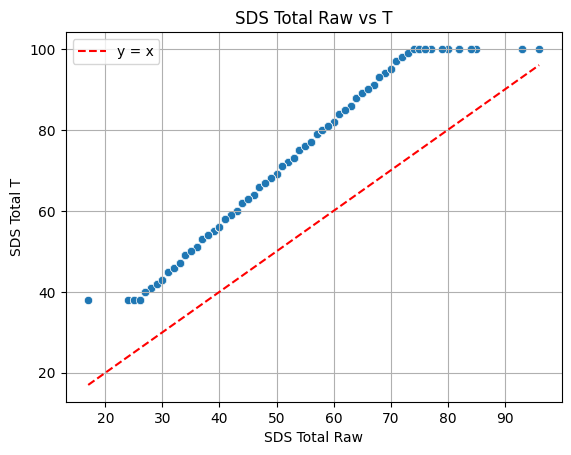

In [192]:
sns.scatterplot(
    x='SDS-SDS_Total_Raw',
    y='SDS-SDS_Total_T',
    data=train_df
)
plt.plot([train_df['SDS-SDS_Total_Raw'].min(), train_df['SDS-SDS_Total_Raw'].max()],
         [train_df['SDS-SDS_Total_Raw'].min(), train_df['SDS-SDS_Total_Raw'].max()],
         color='red', linestyle='--', label='y = x')
plt.legend()
plt.title('SDS Total Raw vs T')
plt.xlabel('SDS Total Raw')
plt.ylabel('SDS Total T')
plt.grid(True)
plt.show()

/var/folders/60/hg2z_sq10k915qgkzmq5z6km0000gn/T/ipykernel_33116/669775325.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


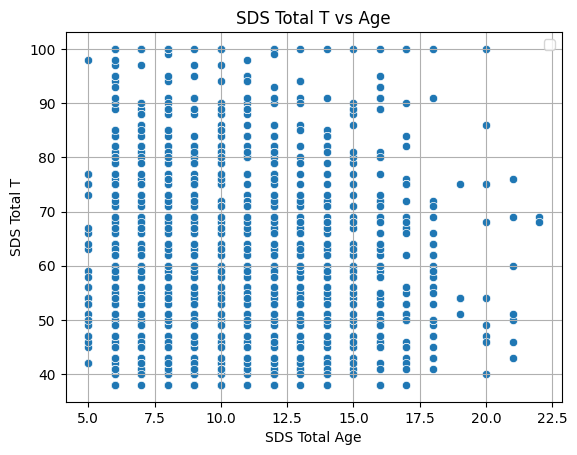

In [197]:
sns.scatterplot(
    x='Basic_Demos-Age',
    y='SDS-SDS_Total_T',
    data=train_df
)

plt.legend()
plt.title('SDS Total T vs Age')
plt.xlabel('SDS Total Age')
plt.ylabel('SDS Total T')
plt.grid(True)
plt.show()

/var/folders/60/hg2z_sq10k915qgkzmq5z6km0000gn/T/ipykernel_33116/3724607657.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


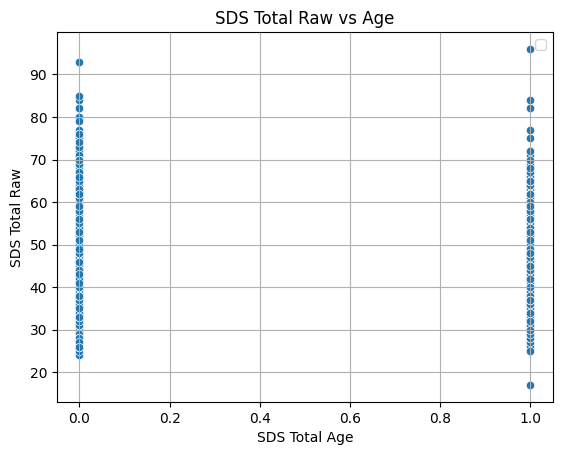

In [205]:
sns.scatterplot(
    x='Basic_Demos-Sex',
    y='SDS-SDS_Total_Raw',
    data=train_df
)

plt.legend()
plt.title('SDS Total Raw vs Age')
plt.xlabel('SDS Total Age')
plt.ylabel('SDS Total Raw')
plt.grid(True)
plt.show()

In [202]:
train_df = train_df.drop(columns=['SDS-SDS_Total_T'])

In [204]:
# 1. Get all columns with missing values
missing_cols = train_df.columns[train_df.isna().any()]

# 2. Get the correlation matrix (numeric columns only)
corr_matrix = train_df.corr(numeric_only=True)

# 3. Define your target columns
target_cols = ['SDS-SDS_Total_Raw']

# 4. Find non-missing columns
non_missing_cols = [col for col in train_df.columns if col not in missing_cols]

# 5. For each target, get sorted correlations with non-missing columns
for target in target_cols:
    print(f"\nTop correlated non-missing columns with {target}:\n")
    if target not in corr_matrix:
        print("No correlation available (likely too many NaNs).")
        continue
    correlations = corr_matrix[target].dropna()
    correlations = correlations[correlations.index.isin(non_missing_cols) & (correlations.index != target)]
    print(f"Found {len(correlations)} valid correlations")
    print(correlations.sort_values(ascending=False).head(10))


Top correlated non-missing columns with SDS-SDS_Total_Raw:

Found 2 valid correlations
Basic_Demos-Age    0.037317
Basic_Demos-Sex   -0.020122
Name: SDS-SDS_Total_Raw, dtype: float64


In [206]:
columns = ['SDS-SDS_Total_Raw', 'Basic_Demos-Age', 'Basic_Demos-Sex']

# Select only these columns for imputation
subset = train_df[columns]

# Run KNN imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
imputed = pd.DataFrame(imputer.fit_transform(subset), columns=columns)

# Replace the imputed columns in the original dataframe
train_df['SDS-SDS_Total_Raw'] = imputed['SDS-SDS_Total_Raw']

/var/folders/60/hg2z_sq10k915qgkzmq5z6km0000gn/T/ipykernel_33116/4184314625.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


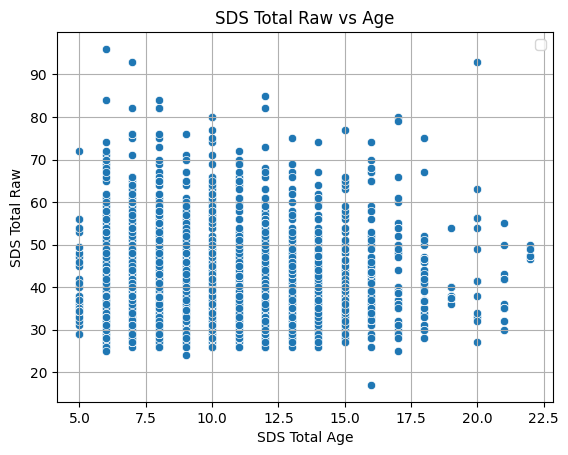

In [208]:
sns.scatterplot(
    x='Basic_Demos-Age',
    y='SDS-SDS_Total_Raw',
    data=train_df
)

plt.legend()
plt.title('SDS Total Raw vs Age')
plt.xlabel('SDS Total Age')
plt.ylabel('SDS Total Raw')
plt.grid(True)
plt.show()

#### Imputing Internet Hours

## **Actigraphy Data**

In [60]:
def time_features(df):
    # Convert time_of_day to hours
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)
    # Basic features 
    features = [
        df["non-wear_flag"].mean(),
        df["enmo"][df["enmo"] >= 0.05].sum(),
    ]
    
    # Define conditions for night, day, and no mask (full data)
    night = ((df["hours"] >= 21) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 6))
    no_mask = np.ones(len(df), dtype=bool)
    
    # List of columns of interest and masks
    keys = ["enmo", "anglez", "light", "battery_voltage"]
    masks = [no_mask, night, day]
    
    # Helper function for feature extraction
    def extract_stats(data):
        return [
            data.mean(), 
            data.std(), 
            data.max(), 
            data.min(), 
            data.diff().mean(), 
            data.diff().std()
        ]
    
    # Iterate over keys and masks to generate the statistics
    for key in keys:
        for mask in masks:
            filtered_data = df.loc[mask, key]
            features.extend(extract_stats(filtered_data))

    return features

def process_file(filename, dirname):
    # Process file and extract time features
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return time_features(df), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    # Load time series from directory in parallel
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [61]:
train_ts = load_time_series("series_train.parquet")


100%|██████████| 996/996 [00:46<00:00, 21.44it/s]


In [62]:
test_ts = load_time_series("series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 11.37it/s]


In [63]:
# Principal Component Analysis
def perform_pca(train, test, n_components=None, random_state=42):
    
    pca = PCA(n_components=n_components, random_state=random_state)
    train_pca = pca.fit_transform(train)
    test_pca = pca.transform(test)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio of the components:\n {explained_variance_ratio}")
    print(np.sum(explained_variance_ratio))
    
    train_pca_df = pd.DataFrame(train_pca, columns=[f'PC_{i+1}' for i in range(train_pca.shape[1])])
    test_pca_df = pd.DataFrame(test_pca, columns=[f'PC_{i+1}' for i in range(test_pca.shape[1])])
    
    return train_pca_df, test_pca_df, pca

In [ ]:
# Processing the time series data and merging with the main dataset
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

scaler = StandardScaler() 
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

for c in df_train.columns:
    m = np.mean(df_train[c])
    df_train[c].fillna(m, inplace=True)
    df_test[c].fillna(m, inplace=True)

print(df_train.shape)

df_train_pca, df_test_pca, pca = perform_pca(df_train, df_test, n_components=15, random_state=SEED)

df_train_pca['id'] = train_ts['id']
df_test_pca['id'] = test_ts['id']

train = pd.merge(train_df, df_train_pca, how="left", on='id')
test = pd.merge(test_df, df_test_pca, how="left", on='id')
train.shape

(996, 74)
Explained variance ratio of the components:
 [0.2297803  0.11595334 0.07236788 0.06201337 0.05346817 0.04800129
 0.0408818  0.03782128 0.03380817 0.02967952 0.02575016 0.0241788
 0.02183349 0.02151956 0.01905743]
0.8361145330748827


(3960, 86)

In [75]:
# Features to exclude, because they're not in test
exclude = ['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii', 'id']

y_model = "PCIAT-PCIAT_Total" # Score, target for the model
y_comp = "sii" # Index, target of the competition
features = [f for f in train.columns if f not in exclude]

In [78]:
class Impute_With_Model:
    
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        
    def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features

    def fit_models(self, model, data, features):
        self.features = features
        n_data = data.shape[0]
        for feature in features:
            self.mean_dict[feature] = np.mean(data[feature])
        for feature in tqdm(features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", np.mean(data[feature]))
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data
    
    def impute_test(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            if feature in exclude:
                continue
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

In [79]:
model = LassoCV(cv=5, random_state=SEED)
imputer = Impute_With_Model(na_frac=0.4) 
# na_frac is the maximum fraction of missing values until which a feature is imputed with the model
# if there are more missing values than for example 40% then we revert to mean imputation
imputer.fit_models(model, train, features)
train_impute = imputer.impute(train)


100%|██████████| 63/63 [00:03<00:00, 15.88it/s]


In [80]:
test_impute = imputer.impute_test(test)

In [74]:
# Checking for Missing Values
print("\n🔍 Missing Values Count:")
print(train_impute.isnull().sum())


🔍 Missing Values Count:
id                 0
Basic_Demos-Age    0
Basic_Demos-Sex    0
CGAS-CGAS_Score    0
Physical-BMI       0
                  ..
PC_11              0
PC_12              0
PC_13              0
PC_14              0
PC_15              0
Length: 86, dtype: int64


In [ ]:
train_impute['PCIAT_Total_Imputed'] = train_impute[['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20']].sum(axis=1)


In [84]:
to_save = train_impute[['id', 'PCIAT_Total_Imputed', 'PCIAT-PCIAT_Total']]
to_save.to_csv("imputed_values.csv", index=False)

In [86]:
train_impute.to_csv("train_imputed_values.csv", index=False)